# ***ANÁLISIS EXPLORATORIO Y TRANFORMACIÓN DE DATOS***

## **Librerías y Carga de Datos**


In [ ]:
#!pip install pandas numpy matplotlib seaborn nltk scipy scikit-learn spacy tqdm wordcloud networkx sentence-transformers
#!python -m download es_core_news_sm

In [ ]:
!pip install spacy
!python -m spacy download es_core_news_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.9/12.9 MB 125.1 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('es_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


### Importación librerías

In [ ]:
# ── Standard library ─────────────────────────────────────────────
import collections
import itertools
import json
import math
import os
import re
import unicodedata
import warnings
from collections import Counter, defaultdict

# ── Core scientific stack ────────────────────────────────────────
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.sparse import hstack
from scipy.stats import chi2_contingency, mannwhitneyu
from tqdm.auto import tqdm

# ── NLP & text processing ────────────────────────────────────────
import nltk
from nltk import bigrams, ngrams
import spacy
import spacy.cli
from wordcloud import WordCloud
from sentence_transformers import SentenceTransformer
from transformers import pipeline

# ── Dimensionality reduction & clustering ────────────────────────
import umap.umap_ as umap
import hdbscan
from sklearn.manifold import TSNE
from itertools import combinations


# ── Scikit-learn ecosystem ───────────────────────────────────────
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import (
    CountVectorizer,
    TfidfVectorizer,
)
from sklearn.feature_selection import chi2, mutual_info_classif
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import (
    StratifiedKFold,
    cross_validate,
    cross_val_score,
    train_test_split,
)
from sklearn.pipeline import Pipeline, make_union
from sklearn.preprocessing import FunctionTransformer
from sklearn.svm import LinearSVC

# ── Imbalanced-learn ─────────────────────────────────────────────
from imblearn.ensemble import BalancedRandomForestClassifier

# ── Deep learning frameworks ─────────────────────────────────────
import torch

# ── Plot defaults ────────────────────────────────────────────────
plt.rcParams["figure.figsize"] = (7, 4)

from sklearn.svm import LinearSVC


In [ ]:
import spacy
nlp = spacy.load("es_core_news_sm")
if "sentencizer" not in nlp.pipe_names:
    nlp.add_pipe("sentencizer")

In [ ]:
os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
root_dir = "/content/drive/MyDrive/PDG/"
#root_dir = r"/content/drive/MyDrive/Proyecto-de-Grado-RAD-Alert/Oficial/Ahora-si-este-fue/data/"

In [ ]:
path = root_dir + "datos.xlsx"

### Definición ruta archivos

In [ ]:
df = pd.read_excel(path)

In [ ]:
df.shape

(3742, 5)

## **Limpieza y Transformación de Datos**

En esta fase, se preparó el corpus de informes radiológicos para el análisis posterior aplicando tres pasos clave. Primero, se **normalizó** el texto convirtiendo todo a minúsculas y eliminando tildes o caracteres especiales con `unicodedata` y expresiones regulares. Luego, se **limpió** el conjunto de datos: se renombraron columnas para mayor claridad, se eliminaron filas con valores nulos en campos esenciales y se filtraron frases irrelevantes (por ejemplo, mediciones de DLP). Finalmente, se **fusionaron** las cuatro columnas de interés (`técnica`, `datos_clínicos`, `hallazgos` y `opinión`) en una sola columna `texto` y se descartaron duplicados, asegurando que cada entrada fuera única y representativa.

### Remover los posibles nulos que tengamos

In [ ]:
print(df.info(), "\n")
print(df.head(), "\n")
print("Nulos por columna:\n", df.isna().sum(), "\n")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3742 entries, 0 to 3741
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Técnica           3739 non-null   object
 1   Datos Clínicos    3738 non-null   object
 2   Hallazgos         3739 non-null   object
 3   Opinión           3740 non-null   object
 4   Hallazgo Crítico  3742 non-null   int64 
dtypes: int64(1), object(4)
memory usage: 146.3+ KB
None 

                                             Técnica  \
0  En equipo multidetector, se realizan cortes ax...   
1  Se realizan cortes axiales desde fosa posterio...   
2  En equipo multidetector, se realizan cortes ax...   
3  Se realizan cortes axiales desde fosa posterio...   
4  \nEn equipo multidetector, se realizan cortes ...   

                                      Datos Clínicos  \
0  Cefalea intensa con signos de alarma. Descarta...   
1                 TCE. CEFALEA Y EMESIS PERSISTENTE.   
2  CEFAL

Muestra información general del DataFrame (df), las primeras filas y la cantidad de valores nulos por columna. Sirve para tener un primer diagnóstico de la calidad y estructura de los datos.

### Cambio de nombre de las variables.

In [ ]:
df.rename(columns={"Hallazgo Crítico": "etiqueta"}, inplace=True)
df.rename(columns={"Técnica": "tecnica"}, inplace=True)
df.rename(columns={"Datos Clínicos": "datos_clinicos"}, inplace=True)
df.rename(columns={"Hallazgos": "hallazgos"}, inplace=True)
df.rename(columns={"Hallazgo Crítico": "etiqueta"}, inplace=True)
df.rename(columns={"Opinión": "opinion"}, inplace=True)

Estandariza y simplifica los nombres de las columnas para facilitar el trabajo posterior. Por ejemplo, "Hallazgo Crítico" pasa a ser "etiqueta", y así sucesivamente.

### Remover los nulos

In [ ]:
df = df.dropna(subset=["datos_clinicos","hallazgos", "opinion"]).reset_index(drop=True)

In [ ]:
print("Nulos por columna:\n", df.isna().sum(), "\n")

Nulos por columna:
 tecnica           3
datos_clinicos    0
hallazgos         0
opinion           0
etiqueta          0
dtype: int64 



Elimina todas las filas que tienen datos faltantes (nulos) en las columnas consideradas esenciales para el análisis (datos_clinicos, hallazgos y opinion). Y despues verifica que ya no queden nulos en las columnas seleccionadas tras el filtrado anterior.

### Normalización de los datos

In [ ]:
def normalize_text(text: str) -> str:
    s = str(text).lower()
    s = unicodedata.normalize("NFKD", s)\
        .encode("ascii", "ignore")\
        .decode("utf-8")
    return re.sub(r"\s+", " ", s).strip()

tqdm.pandas()
def preprocess(text):
    return normalize_text(text)

df["tecnica"] = df["tecnica"].progress_apply(preprocess)
df["datos_clinicos"] = df["datos_clinicos"].progress_apply(preprocess)
df["hallazgos"] = df["hallazgos"].progress_apply(preprocess)
df["opinion"] = df["opinion"].progress_apply(preprocess)

  0%|          | 0/3733 [00:00<?, ?it/s]

  0%|          | 0/3733 [00:00<?, ?it/s]

  0%|          | 0/3733 [00:00<?, ?it/s]

  0%|          | 0/3733 [00:00<?, ?it/s]

Convierte todo el texto a minúsculas, elimina tildes/caracteres especiales y normaliza los espacios. Esto homogeneiza los textos y facilita su análisis. Y luego limpia y normaliza cada texto en las columnas seleccionadas utilizando la función definida antes. tqdm.pandas() sirve para mostrar una barra de progreso al aplicar la función fila por fila.

In [ ]:
def remove_dlp_phrases(text: str) -> str:
    pattern = re.compile(r'\b\d+(?:\.\d+)?\s*DLP\s*\(mGy\s*-\s*cm\)\b', flags=re.IGNORECASE)
    cleaned = pattern.sub('', text or '')
    return re.sub(r'\s{2,}', ' ', cleaned).strip()

df['tecnica'] = df['tecnica'].astype(str).apply(remove_dlp_phrases)

print(df['tecnica'].head())


0    en equipo multidetector, se realizan cortes ax...
1    se realizan cortes axiales desde fosa posterio...
2    en equipo multidetector, se realizan cortes ax...
3    se realizan cortes axiales desde fosa posterio...
4    en equipo multidetector, se realizan cortes ax...
Name: tecnica, dtype: object


Elimina frases que contienen valores de dosis ("DLP (mGy-cm)") en la columna tecnica, ya que esta columna estaba dando un data leakage.

In [ ]:
df.head()

,tecnica,datos_clinicos,hallazgos,opinion,etiqueta
0,"en equipo multidetector, se realizan cortes ax...",cefalea intensa con signos de alarma. descarta...,area de hipodensidad en la sustancia blanca su...,hipodensidad descrita en el lobulo frontal izq...,0
1,se realizan cortes axiales desde fosa posterio...,tce. cefalea y emesis persistente.,signos de sangrado. hematoma subdural: no. hem...,estudio sin evidencia de lesiones traumaticas ...,0
2,"en equipo multidetector, se realizan cortes ax...",cefalea con signos de alarma. dx mielomeningoc...,area encefalomalacia quistica adyacente al ast...,disgenesia de cuerpo calloso y malformacion ch...,0
3,se realizan cortes axiales desde fosa posterio...,trauma facial y trauma craneo encefalico.,signos de sangrado. hematoma subdural: no. hem...,hematoma subgaleal frontal derecho. no se obse...,0
4,"en equipo multidetector, se realizan cortes ax...",alteracion del estado de consiencia.,surcos y espacio subaracnoideo prominentes por...,signos de perdida de volumen cerebral y cambio...,1


<ipython-input-19-7e0925357212>:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="etiqueta", data=df, palette="viridis")


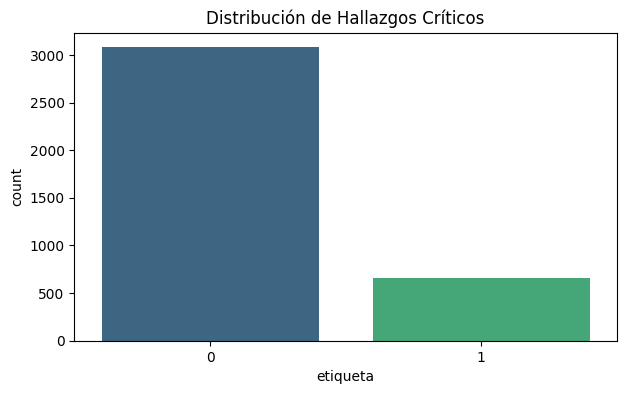

In [ ]:
sns.countplot(x="etiqueta", data=df, palette="viridis")
plt.title("Distribución de Hallazgos Críticos"); plt.show()

In [ ]:
import re

def remove_dlp_phrases(text: str) -> str:
    pattern = re.compile(r'\b\d+(?:\.\d+)?\s*DLP\s*\(mGy\s*-\s*cm\)', flags=re.IGNORECASE)
    cleaned = pattern.sub('', text or '')
    return re.sub(r'\s{2,}', ' ', cleaned).strip()

df['tecnica'] = df['tecnica'].astype(str).apply(remove_dlp_phrases)

print(df['tecnica'].head())


0    en equipo multidetector, se realizan cortes ax...
1    se realizan cortes axiales desde fosa posterio...
2    en equipo multidetector, se realizan cortes ax...
3    se realizan cortes axiales desde fosa posterio...
4    en equipo multidetector, se realizan cortes ax...
Name: tecnica, dtype: object


etiqueta
0    3079
1     654
Name: count, dtype: int64


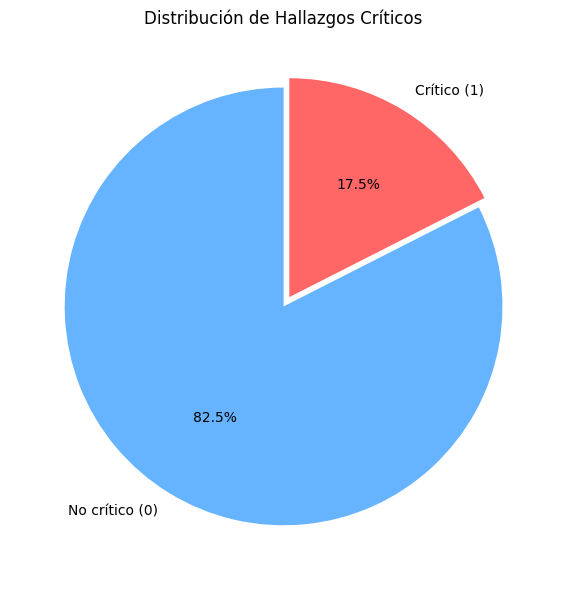

In [ ]:
label_counts = df["etiqueta"].value_counts().sort_index()
print(label_counts)
labels = ["No crítico (0)", "Crítico (1)"] if set(label_counts.index) == {0,1} else label_counts.index.astype(str)

plt.figure(figsize=(6,6))
plt.pie(label_counts,
        labels=labels,
        autopct='%1.1f%%',
        startangle=90,
        colors=['#66b3ff', '#ff6666'],
        explode=[0, 0.05])
plt.title("Distribución de Hallazgos Críticos")
plt.tight_layout()
plt.show()


Unir Columnas Relevantes

Vemos que tenemos un problema en cuanto a la proporción de los datos ya que están desbalanceados

In [ ]:
TEXT_COLS = ["datos_clinicos","hallazgos", "opinion"]
df["texto"]   = df[TEXT_COLS].astype(str).agg(" ".join, axis=1)
print(df["texto"])

0       en equipo multidetector, se realizan cortes ax...
1       se realizan cortes axiales desde fosa posterio...
2       en equipo multidetector, se realizan cortes ax...
3       se realizan cortes axiales desde fosa posterio...
4       en equipo multidetector, se realizan cortes ax...
                              ...                        
3728    medio de contraste: no aplica en equipo multid...
3729    ; medio de contraste iopramida 100 ml: 100 ml;...
3730    ; medio de contraste iopramida 100 ml: 100 ml;...
3731    medio de contraste: no aplica se realizan cort...
3732    en equipo multidetector, se realizo una adquis...
Name: texto, Length: 3733, dtype: object


### Remover las filas repetidas.

In [ ]:
n_total = len(df)
n_unique = df["texto"].nunique()
df = df.drop_duplicates(subset=["texto"], keep="first").reset_index(drop=True)
print(f"Filas totales tras limpieza: {n_total}")
print(f"Textos únicos:            {n_unique}")
print(f"Filas duplicadas:         {n_total - n_unique}")

Filas totales tras limpieza: 3733
Textos únicos:            3393
Filas duplicadas:         340


etiqueta
0    2754
1     639
Name: count, dtype: int64


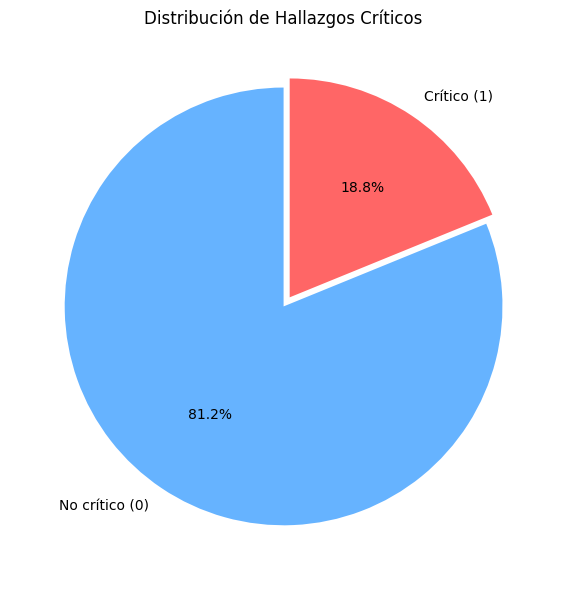

In [ ]:
label_counts = df["etiqueta"].value_counts().sort_index()
print(label_counts)
labels = ["No crítico (0)", "Crítico (1)"] if set(label_counts.index) == {0,1} else label_counts.index.astype(str)

plt.figure(figsize=(6,6))
plt.pie(label_counts,
        labels=labels,
        autopct='%1.1f%%',
        startangle=90,
        colors=['#66b3ff', '#ff6666'],
        explode=[0, 0.05])
plt.title("Distribución de Hallazgos Críticos")
plt.tight_layout()
plt.show()


Se vuelve a graficar la distribución de etiquetas (con el gráfico de pastel) para ver si la limpieza de duplicados ha cambiado la proporción de clases.

## **Evaluación Importancia por Columna**

In [ ]:
TEXT_COLS = ["datos_clinicos","hallazgos","opinion"]
y = df["etiqueta"].values

In [ ]:
model = SentenceTransformer(
    "PlanTL-GOB-ES/roberta-base-biomedical-es",
    device="cpu"
)

emb_col = {}
for col in TEXT_COLS:
    emb_col[col] = model.encode(
        df[col].fillna("").astype(str).tolist(),
        batch_size=16,
        show_progress_bar=True,
        device="cpu"
    ).astype(np.float32)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/613 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/504M [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at PlanTL-GOB-ES/roberta-base-biomedical-es and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/504M [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.22M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/542k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/772 [00:00<?, ?B/s]

Batches:   0%|          | 0/213 [00:00<?, ?it/s]

Batches:   0%|          | 0/213 [00:00<?, ?it/s]

Batches:   0%|          | 0/213 [00:00<?, ?it/s]

Genera representaciones numéricas (embeddings) de cada columna de texto relevante usando un modelo de lenguaje especializado en textos biomédicos en españo. Cada embedding condensa el significado semántico de las frases y permite analizarlas matemáticamente.

### Filter method

In [ ]:
print("TEXT_COLS:", TEXT_COLS)
print("emb_col keys:", emb_col.keys())

TEXT_COLS: ['datos_clinicos', 'hallazgos', 'opinion']
emb_col keys: dict_keys(['datos_clinicos', 'hallazgos', 'opinion'])


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing      import KBinsDiscretizer
from sklearn.feature_selection  import mutual_info_classif

disc = KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='uniform')
vectorizer = TfidfVectorizer(
    min_df=3,
    max_df=0.9,
    ngram_range=(1, 2),
    sublinear_tf=True
)

for col in TEXT_COLS:
    texts = df[col].fillna("")
    Xc = vectorizer.fit_transform(texts).toarray()
    Xc_disc = disc.fit_transform(Xc)
    mi = mutual_info_classif(
        Xc_disc, y,
        discrete_features=True,
        random_state=42
    )
    print(f"{col:<15} MI medio = {np.nanmean(mi):.3f}")


datos_clinicos  MI medio = 0.001
hallazgos       MI medio = 0.004
opinion         MI medio = 0.003


Utiliza TF-IDF para convertir el texto en características numéricas y luego discretiza los valores.

Calcula la información mutua (MI) entre cada columna de texto y la variable objetivo (etiqueta). Esto mide qué tanto la información en cada columna ayuda a distinguir entre hallazgos críticos y no críticos.

Interpretación: La columna hallazgos contiene la mayor cantidad de información relevante para predecir la etiqueta, seguida de opinion, mientras que datos_clinicos aporta poco valor por sí sola.

### Wrapper

In [ ]:
cv = StratifiedKFold(5, shuffle=True, random_state=42)
clf = LinearSVC(class_weight="balanced", max_iter=10000)

results = []
for r in range(1, len(TEXT_COLS)+1):
    for subset in combinations(TEXT_COLS, r):
        name = "+".join(subset)

        tf = TfidfVectorizer(
            min_df=3, max_df=0.9,
            ngram_range=(1,2), sublinear_tf=True
        )
        combined = df[list(subset)].astype(str).agg(" ".join, axis=1)
        X_tfidf = tf.fit_transform(combined)

        X_emb = np.hstack([emb_col[c] for c in subset])

        X = hstack([X_tfidf, X_emb])

        cv_res = cross_validate(
            clf, X, y, cv=cv,
            scoring={"recall":"recall", "f1":"f1"},
            n_jobs=-1
        )
        results.append({
            "features": name,
            "recall":  np.mean(cv_res["test_recall"]),
            "f1":      np.mean(cv_res["test_f1"])
        })

df_results = pd.DataFrame(results)
df_results = df_results.sort_values(
    ["recall","f1"], ascending=[False, False]
).reset_index(drop=True)

print(df_results)


                           features    recall        f1
0                 hallazgos+opinion  0.846641  0.829491
1                           opinion  0.827904  0.806981
2  datos_clinicos+hallazgos+opinion  0.812180  0.811548
3                         hallazgos  0.806053  0.795126
4            datos_clinicos+opinion  0.794931  0.783499
5          datos_clinicos+hallazgos  0.762180  0.769183
6                    datos_clinicos  0.533748  0.420314


Evalúa, para todas las combinaciones posibles de columnas de texto, el desempeño de un clasificador SVM con TF-IDF y embeddings como entrada.

Utiliza validación cruzada para obtener el recall y f1-score promedio de cada combinación de textos.

La mejor combinación es hallazgos+opinion, que logra el mejor recall y f1-score, lo que sugiere que la opinión del radiólogo junto con los hallazgos descriptivos son las partes del informe más predictivas de la criticidad.

Usar solo datos_clinicos resulta insuficiente para distinguir informes críticos pero incluirlos puede mejorar la predicción.

Incluir todas las columnas no necesariamente mejora el desempeño sobre usar solo las más relevantes.

### Embedded

In [ ]:
texts4 = df[TEXT_COLS].astype(str).agg(" ".join, axis=1)
X_tfidf = TfidfVectorizer(min_df=3, max_df=0.9,
                          ngram_range=(1,2), sublinear_tf=True
                         ).fit_transform(texts4)
X_emb   = np.hstack([emb_col[c] for c in TEXT_COLS])
X_all   = hstack([X_tfidf, X_emb])

clf = BalancedRandomForestClassifier(
    n_estimators=200, random_state=42
)
clf.fit(X_all, y)

imp = clf.feature_importances_
start=0
print("\n Importancias BalancedRF")
sizes = [X_tfidf.shape[1]] + [emb_col[c].shape[1] for c in TEXT_COLS]
for label, size in zip(["TF-IDF_all"]+TEXT_COLS, sizes):
    stop = start + size
    print(f"{label:<12} Imp = {imp[start:stop].sum():.3f}")
    start = stop



 Importancias BalancedRF
TF-IDF_all   Imp = 0.178
datos_clinicos Imp = 0.106
hallazgos    Imp = 0.265
opinion      Imp = 0.452


Entrena un Random Forest balanceado utilizando tanto los TF-IDF de todos los textos combinados como los embeddings de cada columna por separado.

Calcula la importancia total que el modelo asigna a cada grupo de características (palabras de todo el texto, embeddings de cada sección).

Los embeddings de la columna opinion (la impresión del radiólogo) tienen el mayor peso en las decisiones del modelo, seguidos de hallazgos.

datos_clinicos y el TF-IDF general aportan menos a la predicción.

Refuerza la idea de que la interpretación del radiólogo es clave para identificar casos críticos.

La información más útil para clasificar hallazgos críticos está en las secciones de hallazgos y opinion de los informes, donde los radiólogos describen y evalúan los resultados.

La sección datos_clinicos por sí sola aporta poca capacidad predictiva, probablemente porque contiene datos más generales o antecedentes, menos relacionados directamente con la criticidad del hallazgo.

La combinación de técnicas de NLP clásicas (TF-IDF) y modernas (embeddings) mejora la capacidad de los modelos para entender el contexto clínico y semántico.

La selección de características es clave: No siempre más información significa mejor rendimiento; enfocarse en las partes más relevantes del texto (según la importancia y la información mutua) permite construir modelos más efectivos y eficientes.

Desde la perspectiva clínica, los resultados tienen sentido, ya que la valoración experta (opinión) y la descripción detallada de hallazgos son esenciales para identificar situaciones críticas.

## **Análisis Exploratorio de Datos**

### Métricas de longitud y negación

etiqueta                 0           1
n_words count  2754.000000  639.000000
        mean    120.782135  188.100156
        std      39.308633   77.360225
        min      12.000000   41.000000
        25%      93.000000  136.000000
        50%     113.000000  174.000000
        75%     143.000000  217.500000
        max     343.000000  657.000000
n_sent  count  2754.000000  639.000000
        mean     13.818446   15.478873
        std       5.327257    7.110135
        min       1.000000    3.000000
        25%      10.000000   10.000000
        50%      13.000000   13.000000
        75%      17.000000   21.000000
        max      35.000000   43.000000
n_neg   count  2754.000000  639.000000
        mean      6.660857    5.010955
        std       2.760789    3.131127
        min       0.000000    0.000000
        25%       5.000000    3.000000
        50%       7.000000    4.000000
        75%       8.000000    7.000000
        max      18.000000   19.000000

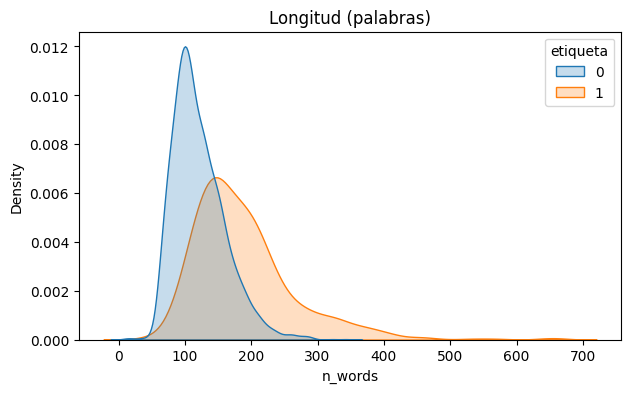

In [ ]:
def n_sent(text): return len(list(nlp(text).sents))
df["texto"]   = df[TEXT_COLS].astype(str).agg(" ".join, axis=1)
df["n_words"] = df["texto"].str.split().str.len()
df["n_sent"]  = df["texto"].apply(n_sent)
df["n_neg"]   = df["texto"].str.count(r"\b(no|sin|ni)\b", flags=re.I)

stats = df.groupby("etiqueta")[["n_words","n_sent","n_neg"]].describe().T
display(stats)

sns.kdeplot(data=df, x="n_words", hue="etiqueta", common_norm=False, fill=True)
plt.title("Longitud (palabras)"); plt.show()

Este gráfico de densidad compara la cantidad de palabras (n_words) en los informes no críticos (etiqueta=0, azul) y críticos (etiqueta=1, naranja).

Los informes críticos tienden a ser más largos.
La media para los informes no críticos es de ~121 palabras, mientras que para los críticos es de ~188 palabras.

Los informes críticos son más variables en longitud (mayor desviación estándar y una cola más larga), reflejando casos más complejos o detallados.

Conclusión clínica:
Los informes críticos pueden requerir mayor nivel de detalle o descripción por parte del radiólogo, lo que se traduce en textos más extensos.

### Top tokens y bigramas por clase (sin quitar stop-words)

In [ ]:
def top_terms(token_lists, n=20):
    return Counter(itertools.chain.from_iterable(token_lists)).most_common(n)

def top_bigrams(token_lists, n=20):
    bgs = (bigrams(t) for t in token_lists)
    cnt = Counter(itertools.chain.from_iterable(bgs)).most_common(n)
    return ["_".join(b) for b,_ in cnt]

df["tokens"] = df["texto"].str.split()
TOP_N=20
for lab in [0,1]:
    subset = df.loc[df.etiqueta==lab,"tokens"]
    print(f"\nClase {lab} — Top {TOP_N} palabras:")
    print(top_terms(subset,TOP_N))
    print("Top bigramas:", top_bigrams(subset,15))


Clase 0 — Top 20 palabras:
[('de', 29717), ('y', 11029), ('la', 8143), ('no', 7840), ('en', 5295), ('del', 5096), ('con', 4944), ('no.', 4438), ('las', 4413), ('sin', 4155), ('o', 3689), ('normal.', 3524), ('signos', 3510), ('evidencia', 3106), ('se', 2999), ('normales.', 2907), ('el', 2885), ('linea', 2796), ('por', 2710), ('sistema', 2705)]
Top bigramas: ['de_la', 'signos_de', 'evidencia_de', 'sistema_ventricular', 'de_las', 'no_hay', 'de_hemorragia', 'sustancia_blanca', 'no_se', 'la_sustancia', 'se_observan', 'linea_media', 'la_linea', 'no_evidencia', 'neumatizacion_de']

Clase 1 — Top 20 palabras:
[('de', 9559), ('la', 3790), ('y', 3738), ('del', 2731), ('con', 2586), ('en', 2429), ('el', 1667), ('las', 1553), ('no', 1413), ('se', 1326), ('hematoma', 1037), ('por', 977), ('no.', 960), ('los', 925), ('hemorragia', 853), ('que', 772), ('frontal', 758), ('a', 752), ('cerebral', 743), ('signos', 723)]
Top bigramas: ['de_la', 'de_las', 'en_el', 'signos_de', 'de_los', 'en_la', 'la_linea

In [ ]:
Clase 0 (No crítico):
Palabras frecuentes: “no”, “normal”, “evidencia”, “sin”, “signos”

Bigramas: “no hay”, “no evidencia”, “sistema ventricular”

Clase 1 (Crítico):
Palabras frecuentes: “hematoma”, “hemorragia”, “fractura”, “subaracnoidea”

Bigramas: “hemorragia subaracnoidea”, “sistema ventricular”, “linea media”, “arteria cerebral”

Interpretación
En la clase no crítica predominan frases que descartan patología.

En la clase crítica, los términos aluden a patologías graves, mostrando que el lenguaje clínico se alinea fuertemente con la etiqueta.



### WordClouds filtradas (stop-list mínima)

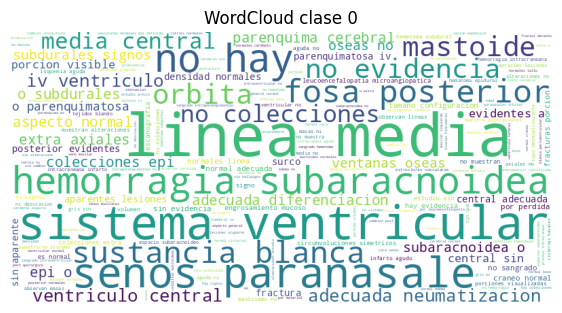

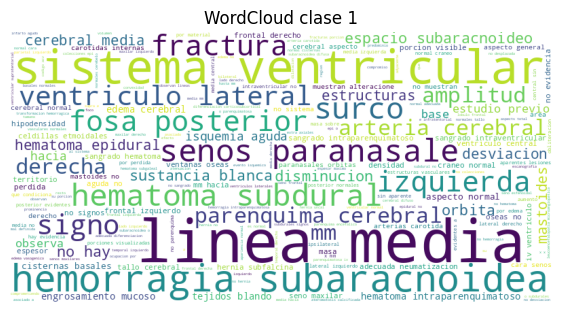

In [ ]:
stop_visual = {"de","la","y","el","en","del","con","se","las","los"}
for lab in [0,1]:
    corpus = df.loc[df.etiqueta==lab,"texto"].str.cat(sep=" ")
    wc = WordCloud(width=800,height=400,background_color="white",
                   stopwords=stop_visual).generate(corpus)
    plt.imshow(wc); plt.axis("off"); plt.title(f"WordCloud clase {lab}")
    plt.show()

Dos nubes de palabras (WordCloud), una para informes no críticos y otra para críticos, donde el tamaño de cada palabra indica su frecuencia.

Clase 0 (No crítico):
Palabras como “no hay”, “sistema ventricular”, “línea media”, y términos como “normal”, “evidencia” dominan la nube, reflejando informes sin hallazgos importantes o con descripciones normales.

Clase 1 (Crítico):
Destacan términos como “hemorragia”, “subaracnoidea”, “fractura”, “hematoma”, además de “sistema ventricular” y “línea media”, asociados a diagnósticos graves.

Conclusión:
Las palabras clave en la clase crítica corresponden a lesiones agudas y hallazgos que requieren atención inmediata, validando la separación lingüística entre clases.

### Información Mutua para n-gramas (1-3)

In [ ]:
vec = TfidfVectorizer(min_df=5,max_df=0.9,ngram_range=(1,3),sublinear_tf=True)
X   = vec.fit_transform(df["texto"])
mi  = mutual_info_classif(X, y, discrete_features=True, random_state=42)
top = np.argsort(mi)[-30:][::-1]
print("\nTop n-gramas MI:")
for w,s in zip(vec.get_feature_names_out()[top], mi[top]):
    print(f"{w:<25} {s:.3f}")

Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/cluster/_supervised.py:59: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/cluster/_supervised.py:59: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/cluster/_supervised.py:59: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/cluster/_supervised.py:59: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warni


Top n-gramas MI:
del                       0.450
con                       0.441
en                        0.435
ventricular               0.414
sistema                   0.413
sistema ventricular       0.412
las                       0.411
el                        0.385
hemorragia                0.372
mastoides                 0.368
senos                     0.364
se                        0.361
orbitas                   0.354
normal                    0.346
paranasales               0.337
sin                       0.333
senos paranasales         0.331
cerebral                  0.321
signos                    0.320
evidencia                 0.319
por                       0.318
signos de                 0.317
surcos                    0.308
los                       0.306
evidencia de              0.304
posterior                 0.292
de las                    0.291
subaracnoidea             0.289
hemorragia subaracnoidea  0.289
izquierdo                 0.286


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/cluster/_supervised.py:59: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/cluster/_supervised.py:59: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/cluster/_supervised.py:59: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/cluster/_supervised.py:59: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.1

Top n-gramas con mayor información mutua:
“ventricular”, “sistema ventricular”, “hemorragia”, “mastoides”, “paranasales”, “subaracnoidea”, etc.

Interpretación:
N-gramas clínicamente relevantes para detectar criticidad son seleccionados automáticamente, lo que valida el pipeline de NLP.

### Embeddings SBERT + UMAP 2-D

Some weights of RobertaModel were not initialized from the model checkpoint at PlanTL-GOB-ES/roberta-base-biomedical-es and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Batches:   0%|          | 0/107 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


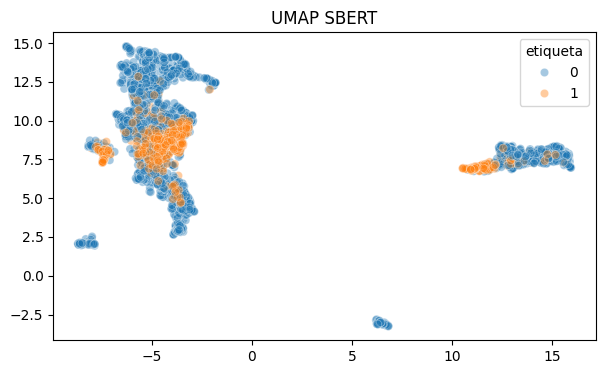

In [ ]:
model = SentenceTransformer("PlanTL-GOB-ES/roberta-base-biomedical-es", device="cpu")
doc_emb = model.encode(df["texto"].tolist(), batch_size=32, show_progress_bar=True)
u2 = umap.UMAP(n_neighbors=30,min_dist=0.1,metric="cosine").fit_transform(doc_emb)
sns.scatterplot(x=u2[:,0],y=u2[:,1],hue=df["etiqueta"],alpha=0.4)
plt.title("UMAP SBERT"); plt.show()

Un gráfico bidimensional donde cada punto es un informe, proyectado a partir de sus embeddings SBERT, coloreado según la clase (azul = no crítico, naranja = crítico).
Patrones claros de agrupamiento:
Los informes críticos tienden a agruparse en regiones específicas del espacio, con algunos solapamientos pero también zonas separadas.

Significa que los modelos de lenguaje son capaces de capturar diferencias semánticas entre textos críticos y no críticos, lo que favorece el desempeño de los modelos de clasificación.

Conclusión:
La estructura semántica de los informes sí diferencia a los casos críticos, apoyando la viabilidad de los métodos de NLP para esta tarea.

### Clustering HDBSCAN + descripción automática

In [ ]:
clusterer = hdbscan.HDBSCAN(min_cluster_size=30,metric="euclidean").fit(u2)
df["cluster"] = clusterer.labels_
def top_tok(k,n=8):
    toks=df[df.cluster==k]["texto"].str.split().explode()
    sw={"de","la","y","el","en","del","con","se","las","los"}
    toks=toks[~toks.isin(sw) & toks.str.len().gt(2)]
    return ", ".join(toks.value_counts().head(n).index.tolist())
for k in sorted(df.cluster.unique()):
    if k==-1: continue
    print(f"Cluster {k} ({(df.cluster==k).sum()} docs):", top_tok(k))

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Cluster 0 (93 docs): sin, base, cerebral, normales., hay, craneo, para, densidad
Cluster 1 (636 docs): no., normal., normales., hematoma, signos, sangrado, craneo:, cerebral:
Cluster 2 (116 docs): hay, signos, por, cambios, sin, involutivos, sistema, ventricular
Cluster 3 (145 docs): sin, arteria, cerebral, signos, media, no., por, hemorragia
Cluster 4 (71 docs): cambios, adecuada, por, evidencia, microangiopatia., lesiones, involutivos., central.
Cluster 5 (110 docs): observan, alteraciones., estructuras, evidencia, hay, visualizadas, parenquima, hemorragia
Cluster 6 (312 docs): observan, alteraciones., evidencia, hay, hemorragia, linea, sistema, ventricular
Cluster 7 (116 docs): lesiones, adecuada, sin, evidencia, normales., central., normal., neumatizacion
Cluster 8 (214 docs): por, signos, adecuada, perdida, sustancia, leucoencefalopatia, blanca, sin
Cluster 9 (182 docs): por, perdida, observan, alteraciones., hay, leucoencefalopatia, microangiopatica., sustancia
Cluster 10 (483 do

Clustering HDBSCAN sobre la proyección UMAP agrupa los informes según similitud semántica.

Los términos más frecuentes por cluster muestran que existen patrones lingüísticos bien definidos en subconjuntos de los datos (por ejemplo, clusters dedicados a “hematoma”, “cambios microangiopáticos”, “sin hallazgos”, etc.).

### NER biomédico (HuggingFace) - Conteo por clase

In [ ]:
ner_med = pipeline("ner",
                   model="fmmolina/bert-base-spanish-wwm-uncased-finetuned-NER-medical",
                   aggregation_strategy="simple",
                   device=0 if torch.cuda.is_available() else -1)

def count_ents(text):
    ents = ner_med(text)
    return Counter(e["entity_group"] for e in ents)

for lab in [0,1]:
    cnt = Counter()
    for txt in df[df.etiqueta==lab]["texto"].head(500):  # sample for speed
        cnt.update(count_ents(txt))
    print(f"\nEntidades frecuentes clase {lab}:")
    print(cnt.most_common(10))

config.json:   0%|          | 0.00/1.13k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/437M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/557 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/248k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/735k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/437M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Device set to use cuda:0
You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset



Entidades frecuentes clase 0:
[('Concept', 36088), ('Action', 10311), ('Predicate', 2328), ('Reference', 17)]

Entidades frecuentes clase 1:
[('Concept', 48159), ('Action', 13362), ('Predicate', 3170), ('Reference', 72)]


Las entidades más frecuentes detectadas son:

“Concept”, “Action”, “Predicate”

Se observa mayor frecuencia de entidades en los informes críticos, dado el mayor detalle descriptivo.



## **Exportación de Datos**

El código divide el conjunto de datos en tres subconjuntos: primero extrae una muestra de 100 informes balanceada por clase como conjunto de prueba (test_df), y luego separa el resto de los datos en conjuntos de entrenamiento (train_df) y validación (val_df), también manteniendo la proporción original de clases (stratify). Además, grafica la distribución de etiquetas en cada subconjunto para verificar el equilibrio y guarda los archivos generados en formato Excel para su posterior análisis y trazabilidad.

In [ ]:
test_df, df = train_test_split(
    df,
    train_size=100,
    stratify=df['etiqueta'],
    random_state=42
)
print(f"Validation: {test_df.shape[0]} filas")

Validation: 100 filas


In [ ]:
train_df, val_df = train_test_split(
    df,
    test_size=0.2,
    stratify=df['etiqueta'],
    random_state=42
)
print(f"Train: {train_df.shape[0]} filas")
print(f"Validation: {val_df.shape[0]} filas")
print(f"Base: {df.shape[0]} filas")

Train: 2634 filas
Validation: 659 filas
Base: 3293 filas


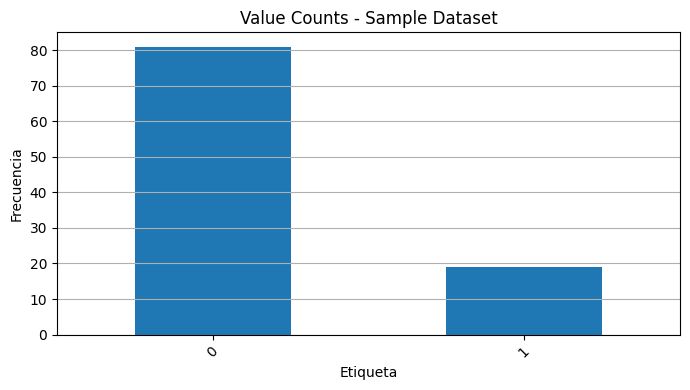

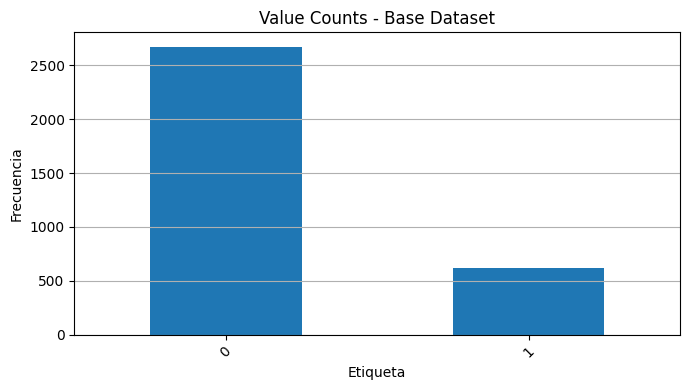

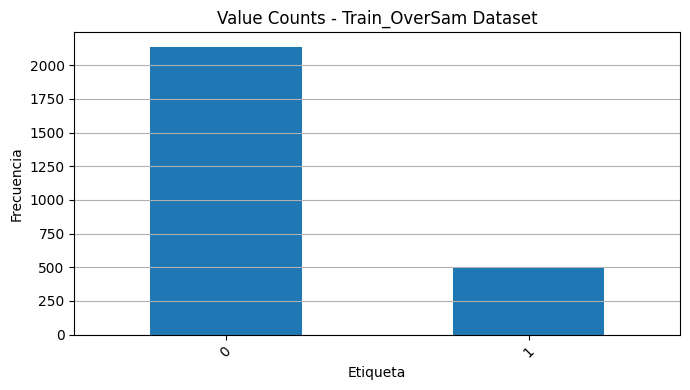

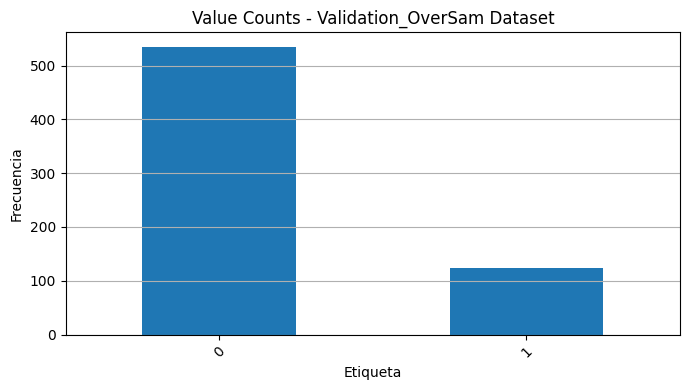

In [ ]:
datasets = {
    "Sample": test_df["etiqueta"].value_counts(),
    "Base": df["etiqueta"].value_counts(),
    "Train_OverSam": train_df["etiqueta"].value_counts(),
    "Validation_OverSam": val_df["etiqueta"].value_counts()
}

for name, counts in datasets.items():
    plt.figure()
    counts.plot(kind='bar')
    plt.title(f'Value Counts - {name} Dataset')
    plt.xlabel('Etiqueta')
    plt.ylabel('Frecuencia')
    plt.grid(axis='y')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


In [ ]:
test_df[['texto', 'etiqueta']].to_excel('/content/drive/MyDrive/PDG/data/test_df.xlsx', index=False)

In [ ]:
val_df[['texto', 'etiqueta']].to_excel('/content/drive/MyDrive/PDG/data/val_df.xlsx', index=False)

In [ ]:
train_df[['texto', 'etiqueta']].to_excel('/content/drive/MyDrive/PDG/data/train_df.xlsx', index=False)

In [ ]:
df[['texto', 'etiqueta']].to_excel('/content/drive/MyDrive/PDG/data/base_df.xlsx', index=False)